# Implementación Red Neuronal con CUDA
## Luis Miguel Henao y Mariana López

### Importación de librerías

In [ ]:
%%writefile mainA.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>
#include <string.h>
#include <cuda_runtime.h>

#define CUDA_CHECK(call) \
    do { \
        cudaError_t err = call; \
        if (err != cudaSuccess) { \
            fprintf(stderr, "Error CUDA en %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(err)); \
            exit(1); \
        } \
    } while (0)

#pragma region Clases y Estructuras

typedef struct
{
    int filas;
    int columnas;
    float *datos;
} Matriz;

// Estructura global para profiling CUDA
typedef struct {
    float cpu_to_gpu;
    float kernel_exec;
    float gpu_to_cpu;
} TimingStats;

TimingStats timing_global = {0, 0, 0};

Matriz *crear_matriz(int filas, int columnas)
{
    Matriz *m = (Matriz *)malloc(sizeof(Matriz));
    m->filas = filas;
    m->columnas = columnas;
    m->datos = (float *)malloc(filas * columnas * sizeof(float));
    return m;
}

#pragma endregion

#pragma region KERNEL CUDA

__global__ void matmul_kernel(float *A, float *B, float *C, int rowsA, int colsA, int colsB)
{
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < rowsA && col < colsB)
    {
        float sum = 0.0f;
        for (int k = 0; k < colsA; k++)
        {
            sum += A[row * colsA + k] * B[k * colsB + col];
        }
        C[row * colsB + col] = sum;
    }
}

#pragma endregion

#pragma region Manipular Matrices

void liberar_matriz(Matriz *m)
{
    if (m)
    {
        if (m->datos) free(m->datos);
        free(m);
    }
}

void inicializar_matriz_aleatoria(Matriz *m)
{
    float escala = 0.1f;
    for (int i = 0; i < m->filas * m->columnas; i++)
    {
        m->datos[i] = (((float)rand() / RAND_MAX) - 0.5f) * escala;
    }
}

void limpiar_matriz(Matriz *m)
{
    memset(m->datos, 0, m->filas * m->columnas * sizeof(float));
}

// Función con instrumentación de profiling
void multiplicar_matrices(Matriz *A, Matriz *B, Matriz *C)
{
    if (A->columnas != B->filas)
    {
        printf("Error Dimensiones: %dx%d * %dx%d\n", A->filas, A->columnas, B->filas, B->columnas);
        exit(1);
    }

    size_t size_A = A->filas * A->columnas * sizeof(float);
    size_t size_B = B->filas * B->columnas * sizeof(float);
    size_t size_C = C->filas * C->columnas * sizeof(float);

    float *d_A, *d_B, *d_C;
    
    // Eventos CUDA para medir tiempos
    cudaEvent_t start, stop;
    float milliseconds = 0;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Reservar memoria en GPU
    CUDA_CHECK(cudaMalloc((void**)&d_A, size_A));
    CUDA_CHECK(cudaMalloc((void**)&d_B, size_B));
    CUDA_CHECK(cudaMalloc((void**)&d_C, size_C));

    // MEDIR: Transferencia CPU→GPU
    cudaEventRecord(start);
    CUDA_CHECK(cudaMemcpy(d_A, A->datos, size_A, cudaMemcpyHostToDevice));
    CUDA_CHECK(cudaMemcpy(d_B, B->datos, size_B, cudaMemcpyHostToDevice));
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&milliseconds, start, stop);
    timing_global.cpu_to_gpu += milliseconds;

    // Configuración del Kernel
    dim3 threadsPerBlock(16, 16);
    dim3 blocksPerGrid((C->columnas + 15) / 16, (C->filas + 15) / 16);

    // MEDIR: Ejecución del Kernel
    cudaEventRecord(start);
    matmul_kernel<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, A->filas, A->columnas, B->columnas);
    cudaEventRecord(stop);
    CUDA_CHECK(cudaGetLastError());
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&milliseconds, start, stop);
    timing_global.kernel_exec += milliseconds;

    // MEDIR: Transferencia GPU→CPU
    cudaEventRecord(start);
    CUDA_CHECK(cudaMemcpy(C->datos, d_C, size_C, cudaMemcpyDeviceToHost));
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&milliseconds, start, stop);
    timing_global.gpu_to_cpu += milliseconds;

    // Liberar GPU
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
    
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
}

void transpuesta(Matriz *A, Matriz *B)
{
    for (int i = 0; i < A->filas; i++)
        for (int j = 0; j < A->columnas; j++)
            B->datos[j * B->columnas + i] = A->datos[i * A->columnas + j];
}

void sumar_sesgo(Matriz *m, Matriz *b)
{
    for (int i = 0; i < m->filas; i++)
        for (int j = 0; j < m->columnas; j++)
            m->datos[i * m->columnas + j] += b->datos[j];
}

void multiplicar_escalar(Matriz *m, float escalar)
{
    for (int i = 0; i < m->filas * m->columnas; i++)
        m->datos[i] *= escalar;
}

void restar_matrices(Matriz *A, Matriz *B)
{
    for (int i = 0; i < A->filas * A->columnas; i++)
        A->datos[i] -= B->datos[i];
}

#pragma endregion

#pragma region Funciones Auxiliares

void relu(Matriz *m)
{
    for (int i = 0; i < m->filas * m->columnas; i++)
        if (m->datos[i] < 0) m->datos[i] = 0;
}

void softmax(Matriz *m)
{
    for (int i = 0; i < m->filas; i++)
    {
        float max_val = -1e9;
        for (int j = 0; j < m->columnas; j++)
            if (m->datos[i * m->columnas + j] > max_val) max_val = m->datos[i * m->columnas + j];

        float sum = 0.0f;
        for (int j = 0; j < m->columnas; j++)
        {
            m->datos[i * m->columnas + j] = expf(m->datos[i * m->columnas + j] - max_val);
            sum += m->datos[i * m->columnas + j];
        }
        for (int j = 0; j < m->columnas; j++)
            m->datos[i * m->columnas + j] /= sum;
    }
}

int argmax(Matriz *m, int row)
{
    float max_val = -1e9;
    int max_index = 0;
    for (int j = 0; j < m->columnas; j++)
    {
        if (m->datos[row * m->columnas + j] > max_val)
        {
            max_val = m->datos[row * m->columnas + j];
            max_index = j;
        }
    }
    return max_index;
}

float calcular_precision(Matriz *predicciones, Matriz *etiquetas)
{
    int correctos = 0;
    for (int i = 0; i < predicciones->filas; i++)
    {
        if (argmax(predicciones, i) == (int)etiquetas->datos[i])
            correctos++;
    }
    return (float)correctos / predicciones->filas;
}

float calcular_loss(Matriz *predicciones, Matriz *etiquetas, int num_clases)
{
    float loss = 0.0f;
    const float epsilon = 1e-12f;
    for (int i = 0; i < predicciones->filas; i++)
    {
        int etiqueta = (int)etiquetas->datos[i];
        float pred = predicciones->datos[i * num_clases + etiqueta];
        pred = fmaxf(pred, epsilon);
        loss += -logf(pred);
    }
    return loss / predicciones->filas;
}

void imprimir_uso_gpu() {
    size_t free_byte ;
    size_t total_byte ;
    cudaError_t cuda_status = cudaMemGetInfo( &free_byte, &total_byte ) ;

    if ( cudaSuccess != cuda_status ){
        printf("Error: cudaMemGetInfo falla %s \n", cudaGetErrorString(cuda_status) );
        return ;
    }

    double free_db = (double)free_byte ;
    double total_db = (double)total_byte ;
    double used_db = total_db - free_db ;

    printf("  [GPU Mem] Usada: %.2f MB | Libre: %.2f MB | Total: %.2f MB\n",
        used_db/1024.0/1024.0, free_db/1024.0/1024.0, total_db/1024.0/1024.0);
}

#pragma endregion

#pragma region Cargar Datos

int convertir_bytes_a_enteros(FILE *fp)
{
    unsigned char buf[4];
    if (fread(buf, sizeof(unsigned char), 4, fp) != 4) return 0;
    return (buf[0] << 24) | (buf[1] << 16) | (buf[2] << 8) | buf[3];
}

Matriz *cargar_imagenes_dataset(const char *filename)
{
    FILE *fp = fopen(filename, "rb");
    if (!fp) { printf("Error abriendo %s\n", filename); exit(1); }

    convertir_bytes_a_enteros(fp);
    int num_imgs = convertir_bytes_a_enteros(fp);
    int rows = convertir_bytes_a_enteros(fp);
    int cols = convertir_bytes_a_enteros(fp);

    Matriz *m = crear_matriz(num_imgs, rows * cols);
    unsigned char temp;
    for (int i = 0; i < m->filas * m->columnas; i++)
    {
        if (fread(&temp, sizeof(unsigned char), 1, fp) != 1) break;
        m->datos[i] = (float)temp / 255.0f;
    }
    fclose(fp);
    return m;
}

Matriz *cargar_etiquetas_dataset(const char *filename)
{
    FILE *fp = fopen(filename, "rb");
    if (!fp) { printf("Error abriendo %s\n", filename); exit(1); }

    convertir_bytes_a_enteros(fp);
    int num_items = convertir_bytes_a_enteros(fp);

    Matriz *m = crear_matriz(num_items, 1);
    unsigned char temp;
    for (int i = 0; i < num_items; i++)
    {
        if (fread(&temp, sizeof(unsigned char), 1, fp) != 1) break;
        m->datos[i] = (float)temp;
    }
    fclose(fp);
    return m;
}

#pragma endregion

int main()
{
    srand(42); // Semilla fija

    const int TAMAÑO_ENTRADA = 784;
    const int TAMAÑO_CAPA_OCULTA = 512;
    const int TAMAÑO_SALIDA = 10;
    const float TASA_APRENDIZAJE = 0.01f;
    const int EPOCAS = 10;
    const int TAMAÑO_BATCH = 512;

    printf("=== MLP en CUDA con Profiling ===\n");
    imprimir_uso_gpu();

    printf("\nCargando datos...\n");
    Matriz *X_train = cargar_imagenes_dataset("./Resources/train-images.idx3-ubyte");
    Matriz *Y_train = cargar_etiquetas_dataset("./Resources/train-labels.idx1-ubyte");
    Matriz *X_test = cargar_imagenes_dataset("./Resources/t10k-images.idx3-ubyte");
    Matriz *Y_test = cargar_etiquetas_dataset("./Resources/t10k-labels.idx1-ubyte");

    float suma_check = 0;
    for(int i=0; i<784; i++) suma_check += X_train->datos[i];
    if(suma_check < 1.0f) { printf("ERROR: Datos vacíos.\n"); return 1; }
    printf("Datos cargados. Train: %d, Test: %d\n", X_train->filas, X_test->filas);

    Matriz *W1 = crear_matriz(TAMAÑO_ENTRADA, TAMAÑO_CAPA_OCULTA);
    inicializar_matriz_aleatoria(W1);
    Matriz *b1 = crear_matriz(1, TAMAÑO_CAPA_OCULTA);
    limpiar_matriz(b1);
    Matriz *W2 = crear_matriz(TAMAÑO_CAPA_OCULTA, TAMAÑO_SALIDA);
    inicializar_matriz_aleatoria(W2);
    Matriz *b2 = crear_matriz(1, TAMAÑO_SALIDA);
    limpiar_matriz(b2);

    Matriz *X_batch = crear_matriz(TAMAÑO_BATCH, TAMAÑO_ENTRADA);
    Matriz *Y_batch = crear_matriz(TAMAÑO_BATCH, 1);
    Matriz *Z1 = crear_matriz(TAMAÑO_BATCH, TAMAÑO_CAPA_OCULTA);
    Matriz *A1 = crear_matriz(TAMAÑO_BATCH, TAMAÑO_CAPA_OCULTA);
    Matriz *Z2 = crear_matriz(TAMAÑO_BATCH, TAMAÑO_SALIDA);
    Matriz *A2 = crear_matriz(TAMAÑO_BATCH, TAMAÑO_SALIDA);
    Matriz *dZ2 = crear_matriz(TAMAÑO_BATCH, TAMAÑO_SALIDA);
    Matriz *dW2 = crear_matriz(TAMAÑO_CAPA_OCULTA, TAMAÑO_SALIDA);
    Matriz *db2 = crear_matriz(1, TAMAÑO_SALIDA);
    Matriz *A1_T = crear_matriz(TAMAÑO_CAPA_OCULTA, TAMAÑO_BATCH);
    Matriz *dZ1 = crear_matriz(TAMAÑO_BATCH, TAMAÑO_CAPA_OCULTA);
    Matriz *dW1 = crear_matriz(TAMAÑO_ENTRADA, TAMAÑO_CAPA_OCULTA);
    Matriz *db1 = crear_matriz(1, TAMAÑO_CAPA_OCULTA);
    Matriz *W2_T = crear_matriz(TAMAÑO_SALIDA, TAMAÑO_CAPA_OCULTA);
    Matriz *X_batch_T = crear_matriz(TAMAÑO_ENTRADA, TAMAÑO_BATCH);

    int *indices = (int *)malloc(X_train->filas * sizeof(int));
    for (int k = 0; k < X_train->filas; k++) indices[k] = k;

    clock_t inicio_total = clock();

    printf("\nIniciando Entrenamiento...\n");
    for (int epoca = 0; epoca < EPOCAS; epoca++)
    {
        clock_t inicio_epoca = clock();

        for (int k = X_train->filas - 1; k > 0; k--)
        {
            int j = rand() % (k + 1);
            int temp = indices[k]; indices[k] = indices[j]; indices[j] = temp;
        }

        for (int i = 0; i < X_train->filas; i += TAMAÑO_BATCH)
        {
            int batch_actual = (i + TAMAÑO_BATCH > X_train->filas) ? X_train->filas - i : TAMAÑO_BATCH;

            for (int b = 0; b < batch_actual; b++)
            {
                int idx = indices[i + b];
                memcpy(&X_batch->datos[b * TAMAÑO_ENTRADA], &X_train->datos[idx * TAMAÑO_ENTRADA], TAMAÑO_ENTRADA * sizeof(float));
                Y_batch->datos[b] = Y_train->datos[idx];
            }

            X_batch->filas = batch_actual; Z1->filas = batch_actual; A1->filas = batch_actual;
            Z2->filas = batch_actual; A2->filas = batch_actual;

            multiplicar_matrices(X_batch, W1, Z1);
            sumar_sesgo(Z1, b1);
            memcpy(A1->datos, Z1->datos, batch_actual * TAMAÑO_CAPA_OCULTA * sizeof(float));
            relu(A1);

            multiplicar_matrices(A1, W2, Z2);
            sumar_sesgo(Z2, b2);
            memcpy(A2->datos, Z2->datos, batch_actual * TAMAÑO_SALIDA * sizeof(float));
            softmax(A2);

            memcpy(dZ2->datos, A2->datos, batch_actual * TAMAÑO_SALIDA * sizeof(float));
            for (int b = 0; b < batch_actual; b++)
                dZ2->datos[b * TAMAÑO_SALIDA + (int)Y_batch->datos[b]] -= 1.0f;

            A1->filas = batch_actual;
            transpuesta(A1, A1_T);
            multiplicar_matrices(A1_T, dZ2, dW2);
            multiplicar_escalar(dW2, 1.0f / batch_actual);

            limpiar_matriz(db2);
            for (int r = 0; r < batch_actual; r++)
                for (int c = 0; c < TAMAÑO_SALIDA; c++)
                    db2->datos[c] += dZ2->datos[r * TAMAÑO_SALIDA + c];
            multiplicar_escalar(db2, 1.0f / batch_actual);

            transpuesta(W2, W2_T);
            multiplicar_matrices(dZ2, W2_T, dZ1);
            for (int k = 0; k < batch_actual * TAMAÑO_CAPA_OCULTA; k++)
                if (Z1->datos[k] <= 0) dZ1->datos[k] = 0.0f;

            X_batch->filas = batch_actual;
            transpuesta(X_batch, X_batch_T);
            multiplicar_matrices(X_batch_T, dZ1, dW1);
            multiplicar_escalar(dW1, 1.0f / batch_actual);

            limpiar_matriz(db1);
            for (int r = 0; r < batch_actual; r++)
                for (int c = 0; c < TAMAÑO_CAPA_OCULTA; c++)
                    db1->datos[c] += dZ1->datos[r * TAMAÑO_CAPA_OCULTA + c];
            multiplicar_escalar(db1, 1.0f / batch_actual);

            multiplicar_escalar(dW1, TASA_APRENDIZAJE); restar_matrices(W1, dW1);
            multiplicar_escalar(db1, TASA_APRENDIZAJE); restar_matrices(b1, db1);
            multiplicar_escalar(dW2, TASA_APRENDIZAJE); restar_matrices(W2, dW2);
            multiplicar_escalar(db2, TASA_APRENDIZAJE); restar_matrices(b2, db2);
        }

        double tiempo_epoca = (double)(clock() - inicio_epoca) / CLOCKS_PER_SEC;

        Matriz *Z1_eval = crear_matriz(X_train->filas, TAMAÑO_CAPA_OCULTA);
        Matriz *A1_eval = crear_matriz(X_train->filas, TAMAÑO_CAPA_OCULTA);
        Matriz *Z2_eval = crear_matriz(X_train->filas, TAMAÑO_SALIDA);
        Matriz *A2_eval = crear_matriz(X_train->filas, TAMAÑO_SALIDA);

        multiplicar_matrices(X_train, W1, Z1_eval);
        sumar_sesgo(Z1_eval, b1);
        memcpy(A1_eval->datos, Z1_eval->datos, X_train->filas * TAMAÑO_CAPA_OCULTA * sizeof(float));
        relu(A1_eval);
        multiplicar_matrices(A1_eval, W2, Z2_eval);
        sumar_sesgo(Z2_eval, b2);
        memcpy(A2_eval->datos, Z2_eval->datos, X_train->filas * TAMAÑO_SALIDA * sizeof(float));
        softmax(A2_eval);

        float acc = calcular_precision(A2_eval, Y_train);
        float loss = calcular_loss(A2_eval, Y_train, TAMAÑO_SALIDA);

        printf("Epoca %d/%d | Tiempo: %.2fs | Loss: %.4f | Acc: %.4f",
               epoca + 1, EPOCAS, tiempo_epoca, loss, acc);
        imprimir_uso_gpu();

        liberar_matriz(Z1_eval); liberar_matriz(A1_eval);
        liberar_matriz(Z2_eval); liberar_matriz(A2_eval);
    }

    double total_time = (double)(clock() - inicio_total) / CLOCKS_PER_SEC;
    printf("\nEntrenamiento finalizado en %.2f segundos.\n", total_time);

    // Evaluación Final
    Matriz *Z1_test = crear_matriz(X_test->filas, TAMAÑO_CAPA_OCULTA);
    Matriz *A1_test = crear_matriz(X_test->filas, TAMAÑO_CAPA_OCULTA);
    Matriz *Z2_test = crear_matriz(X_test->filas, TAMAÑO_SALIDA);
    Matriz *A2_test = crear_matriz(X_test->filas, TAMAÑO_SALIDA);

    multiplicar_matrices(X_test, W1, Z1_test);
    sumar_sesgo(Z1_test, b1);
    memcpy(A1_test->datos, Z1_test->datos, X_test->filas * TAMAÑO_CAPA_OCULTA * sizeof(float));
    relu(A1_test);
    multiplicar_matrices(A1_test, W2, Z2_test);
    sumar_sesgo(Z2_test, b2);
    memcpy(A2_test->datos, Z2_test->datos, X_test->filas * TAMAÑO_SALIDA * sizeof(float));
    softmax(A2_test);

    float acc_test = calcular_precision(A2_test, Y_test);
    float loss_test = calcular_loss(A2_test, Y_test, TAMAÑO_SALIDA);

    printf("\n=== RESULTADOS FINALES ===\n");
    printf("Precision en Test: %.2f%%\n", acc_test * 100.0f);
    printf("Loss en Test: %.4f\n", loss_test);

    // PROFILING DETALLADO CUDA
    float total_cuda = timing_global.cpu_to_gpu + timing_global.kernel_exec + timing_global.gpu_to_cpu;
    printf("\n=== PROFILING DETALLADO CUDA ===\n");
    printf("Transferencia CPU→GPU: %.2f ms (%.1f%%)\n", 
           timing_global.cpu_to_gpu, (timing_global.cpu_to_gpu/total_cuda)*100);
    printf("Ejecución Kernels:     %.2f ms (%.1f%%)\n", 
           timing_global.kernel_exec, (timing_global.kernel_exec/total_cuda)*100);
    printf("Transferencia GPU→CPU: %.2f ms (%.1f%%)\n", 
           timing_global.gpu_to_cpu, (timing_global.gpu_to_cpu/total_cuda)*100);
    printf("Total CUDA:            %.2f ms\n", total_cuda);
    printf("Tiempo total programa: %.2f s\n", total_time);

    // Liberar todo
    free(indices);
    liberar_matriz(X_train); liberar_matriz(Y_train);
    liberar_matriz(X_test); liberar_matriz(Y_test);
    liberar_matriz(W1); liberar_matriz(b1);
    liberar_matriz(W2); liberar_matriz(b2);
    liberar_matriz(X_batch); liberar_matriz(Y_batch);
    liberar_matriz(Z1); liberar_matriz(A1);
    liberar_matriz(Z2); liberar_matriz(A2);
    liberar_matriz(dZ2); liberar_matriz(dW2); liberar_matriz(db2);
    liberar_matriz(A1_T); liberar_matriz(dZ1); liberar_matriz(dW1);
    liberar_matriz(db1); liberar_matriz(W2_T); liberar_matriz(X_batch_T);
    liberar_matriz(Z1_test); liberar_matriz(A1_test);
    liberar_matriz(Z2_test); liberar_matriz(A2_test);

    return 0;
}

Writing mainA.cu


### Compilación y ejecución del archivo

In [2]:
!nvcc mainA.cu -o mlp_cuda -arch=sm_75 -lm -O3

"nvcc" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [59]:
!./mlp_cuda

=== MLP en CUDA (Optimizado) ===
  [GPU Mem] Usada: 102.94 MB | Libre: 14992.12 MB | Total: 15095.06 MB

Cargando datos...
Datos cargados correctamente. Train: 60000, Test: 10000

Iniciando Entrenamiento...
Epoca 1/10 | Tiempo: 1.82s | Loss: 1.8704 | Acc: 0.6969  [GPU Mem] Usada: 102.94 MB | Libre: 14992.12 MB | Total: 15095.06 MB
Epoca 2/10 | Tiempo: 1.76s | Loss: 1.4101 | Acc: 0.7743  [GPU Mem] Usada: 102.94 MB | Libre: 14992.12 MB | Total: 15095.06 MB
Epoca 3/10 | Tiempo: 1.50s | Loss: 1.0581 | Acc: 0.8091  [GPU Mem] Usada: 102.94 MB | Libre: 14992.12 MB | Total: 15095.06 MB
Epoca 4/10 | Tiempo: 1.44s | Loss: 0.8473 | Acc: 0.8317  [GPU Mem] Usada: 102.94 MB | Libre: 14992.12 MB | Total: 15095.06 MB
Epoca 5/10 | Tiempo: 1.45s | Loss: 0.7210 | Acc: 0.8462  [GPU Mem] Usada: 102.94 MB | Libre: 14992.12 MB | Total: 15095.06 MB
Epoca 6/10 | Tiempo: 1.44s | Loss: 0.6385 | Acc: 0.8531  [GPU Mem] Usada: 102.94 MB | Libre: 14992.12 MB | Total: 15095.06 MB
Epoca 7/10 | Tiempo: 1.46s | Loss: 0.

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


### Análisis de Profiling CUDA

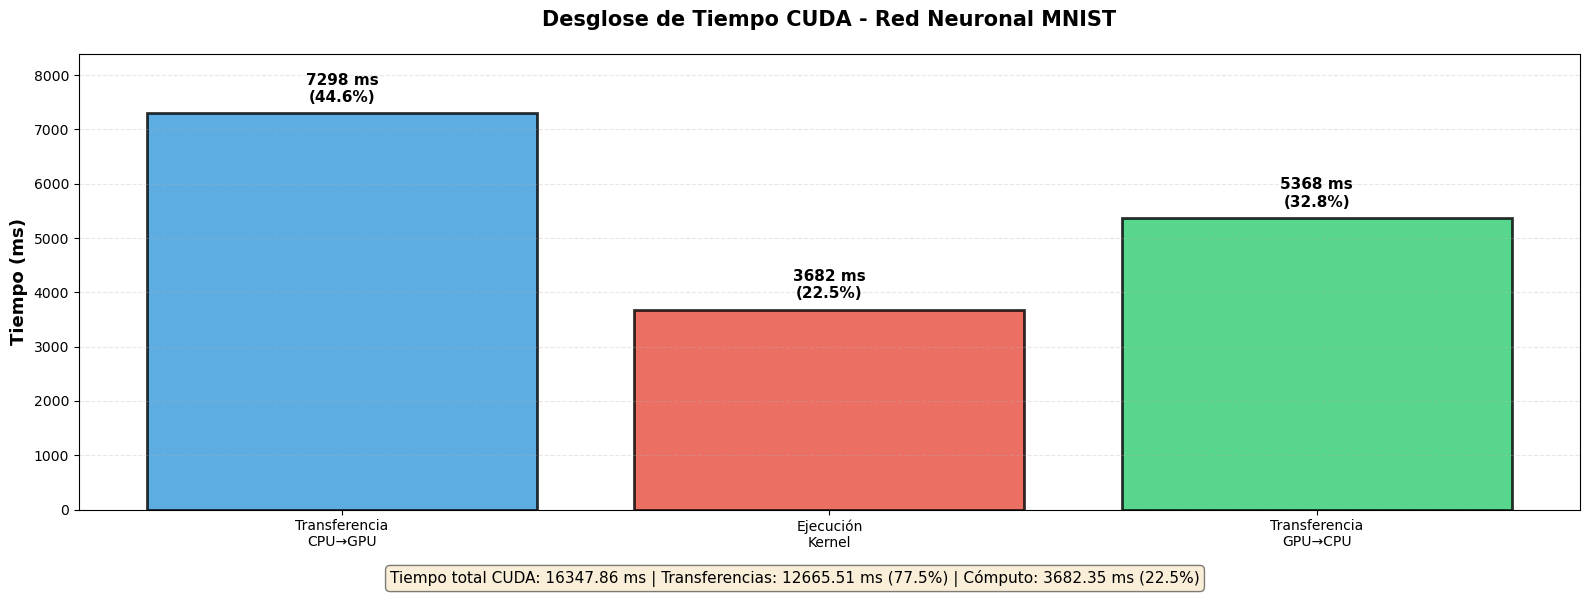

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Datos del profiling CUDA (en milisegundos)
operaciones = ['Transferencia\nCPU→GPU', 'Ejecución\nKernel', 'Transferencia\nGPU→CPU']
tiempos = [7297.69, 3682.35, 5367.82]
porcentajes = [44.6, 22.5, 32.8]
colores = ['#3498db', '#e74c3c', '#2ecc71']

# Crear figura con 2 subgráficos
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

# Gráfico de barras
bars = ax1.bar(operaciones, tiempos, color=colores, edgecolor='black', linewidth=2, alpha=0.8)
ax1.set_ylabel('Tiempo (ms)', fontsize=13, fontweight='bold')
ax1.set_title('Desglose de Tiempo CUDA - Red Neuronal MNIST', fontsize=15, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, max(tiempos) * 1.15)

# Añadir valores en las barras
for i, (bar, tiempo, porcentaje) in enumerate(zip(bars, tiempos, porcentajes)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 150,
             f'{tiempo:.0f} ms\n({porcentaje}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Añadir estadísticas
total_cuda = sum(tiempos)
transferencias = tiempos[0] + tiempos[2]
fig.text(0.5, 0.02, 
         f'Tiempo total CUDA: {total_cuda:.2f} ms | Transferencias: {transferencias:.2f} ms ({(transferencias/total_cuda)*100:.1f}%) | Cómputo: {tiempos[1]:.2f} ms ({porcentajes[1]:.1f}%)',
         ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('cuda_profiling_completo.png', dpi=300, bbox_inches='tight')
plt.show()